<a href="https://colab.research.google.com/github/xSakix/AI_colab_notebooks/blob/master/market_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market play

Simulating market price with Brownian motion. Can an Agent learn to trade with profit on such market? And can this ability be translated into another such market?

## Game

Agent can do 3 actions:

* Buy
* Sell
* Hold

Price is presented as a window. Agent buys at the price at the end of the window.

price window: p0,...,pN

Agent will buy or sell shares with price pN.

Agents starts with:

* cash(t0) - initial investment
* shares(t0) - which are 0 and represent the number of shares


## Reward at time t

The reward at time t is computed as

portfolio value(t) = price(tN)*shares(t) + cash(t)

return(t) = (portfolio value(t) - investment)/investment

where 

* t - current step
* tN - price of shares at the last step 
* shares(t) - number of shares at 't'
* cash(t) - cash at 't'
* investment - start investment in cash, e.g. cash(t0)

## Goal

Have positive return on investment after the simulation run.

## Method

[REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf)


## Results and commentary

### 20200912

The goal needs to be clear. There is a big difference between if we try to save money for retirement in 20 years. And when we are trying to 'game' the market in a short profit scenario.

For now X years horizont has been chosen. In such a scenario the reward is the return on investment at the last step/time/price of simulation.

Removed once per episode learning and now learning at each step (e.g. each step is the loss propagated backwards and a optimised)

### 20200913

Removed env/agent variables from policy 

Changed to compute reward/loss at each step:

<pre>
r(t),s(t),loss(t) = env.step(s(t-1))

R = r(t)+gamma*R

loss(t) = -loss(t)*R
</pre>

then loss is backpropagated. Where

* r(t) - reward at step t
* s(t) - state at step t
* loss(t) - policy loss at step t
* s(t-1) - state at step t-1
* gamma - how much the reward is important for future rewards
* R - cumulative episode reward


Well [REINFORCE](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63) needs to finish the whole episode:D So back to previos implementation:D

### 20200914

Looks like REINFORCE for one episode(one data set) can work. But the loss values can be negative. So let's try to do  change:

if reward < 0:
  reward = 1e^-6 (eps value)

That way we don't get negative rewards and still apply some kind of punishment for it.

The results so far are mixed. The are problems with *stability* of episode rewards and the loss function doesn't always go to -> 0 (which is a problem). 

### 20200916

Had a bug were I added the whole loss with backward prop. to a list and the memory got exhausted. Corrected the error by adding the value itself and not the whole 'object'.

from:

self.overall_loss.append(policy_loss) 

to:

self.overall_loss.append(policy_loss.item())

The results are still mixed...maybe more epochs will help?


In [1]:
import os
import sys
sys.version
sys.version_info

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical

from itertools import count
from collections import deque
from enum import Enum

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats import norm

import matplotlib.pyplot as plt

from google.colab import drive




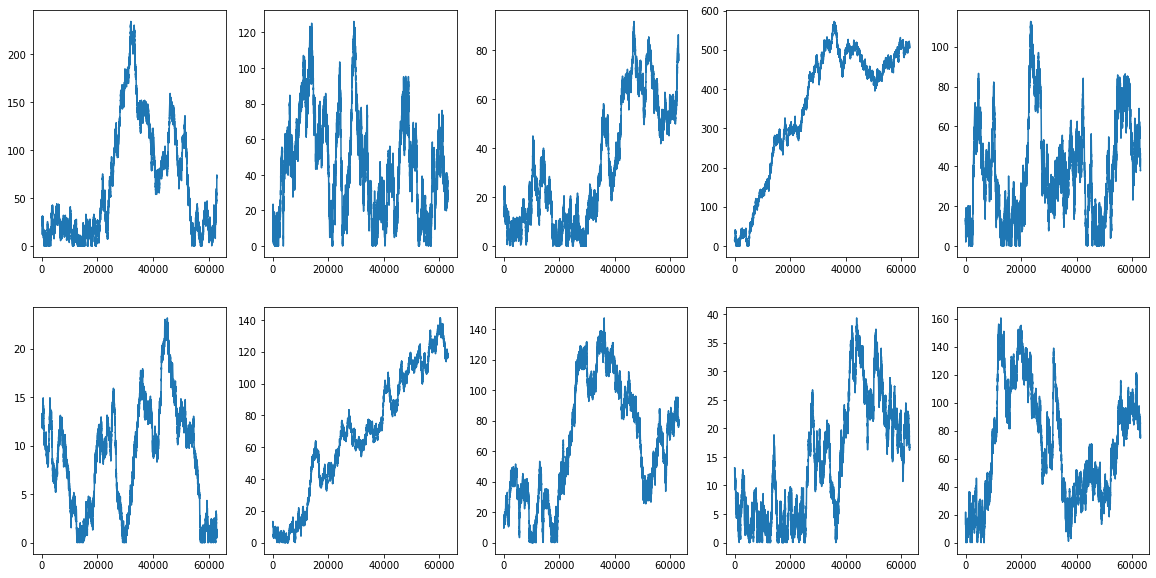

In [2]:
class Generator:
    def generate(self):
        pass


class BrownianGenerator(Generator):
    def __init__(self, sample_size, x0=np.random.randint(10, 100)):
        self.x0 = x0
        self.n = sample_size
        self.dt = np.random.uniform(0., 2.)
        self.delta = np.random.uniform(0., 1.)

    def generate(self):
        x0 = np.asarray(self.x0)
        r = norm.rvs(size=x0.shape + (self.n,), scale=self.delta * np.sqrt(self.dt))
        out = np.empty(r.shape)
        np.cumsum(r, axis=-1, out=out)
        out += np.expand_dims(x0, axis=-1)
        out = np.abs(out)
        return out


# if __name__ == "__main__":

fig, plots = plt.subplots(2,5, figsize=(20,10))

for i in range(2):
  for j in range(5):
    br = BrownianGenerator(63000)
    plots[i][j].plot(br.generate())

plt.show()


In [3]:


class Transform:
    def transform(self, data):
        pass


class SlidingWindow(Transform):
    def __init__(self, window):
        self.window = window

    def transform(self, data):
        assert len(data.shape) == 1
        return _sliding_window(data=data, size=self.window)


# https://gist.github.com/nils-werner/9d321441006b112a4b116a8387c2280c
def _sliding_window(data, size, stepsize=1, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> _sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> _sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided


class MinMaxTransform(Transform):

    def transform(self, data):
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data.reshape(-1, 1))
        return data.reshape(-1)

#-------------------------------------------------------------------------------

samples = BrownianGenerator(63000).generate()
states = SlidingWindow(10).transform(samples)

print(states.size)
print(states[0])


629910
[13.01470204 13.27586864 12.93632346 12.87058761 13.18130998 13.27306146
 13.1066013  13.19994068 12.8646877  12.78949241]


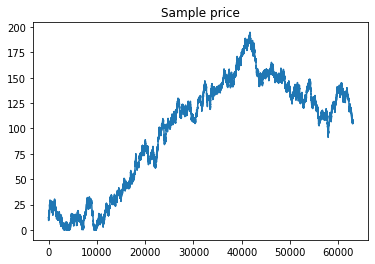

culumative reward: 243650.07059552165


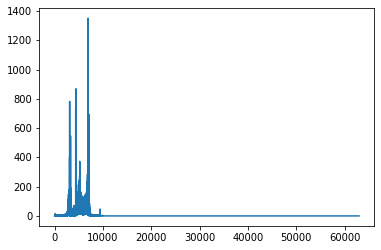

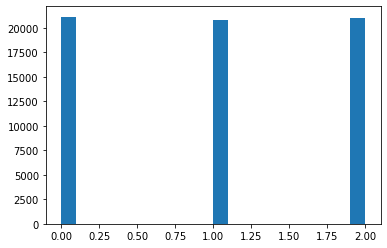

In [4]:
class Actions(Enum):
    HOLD = 0
    BUY = 1
    SELL = 2


class MarketEnv:

    def __init__(self, num_samples=1000, window=30):
        self.samples = BrownianGenerator(num_samples).generate()

        # self.samples = MinMaxTransform().transform(data)
        self.states = SlidingWindow(window).transform(self.samples)
        self.queue = deque(self.states)
        self.shares = 0
        self.cash = 100000.
        self.investment = self.cash

    def reset(self):
        self.shares = 0
        self.cash = 100000.
        self.queue = deque(self.states)
        return self.queue.popleft()

    def step(self, action, state):
        # 0 - Hold, 1 - Buy, 2-Sell

        # commentary

        #So we have a window of price values, e.g. in a week it is 5 values
        #Agent looks at this week development and its the last day of week
        #After he sees that the price has developed in such or such way over the
        #week he decides for the last price to do some of actions (H,B,S)
        #The result is computed based on next week price window
        #The problem is the reward calculation...

        #If we wanna save money for 20 years, then the reward will be the portfolio
        #value in ... 20 years...
        #If we wanna maximize the portfolio value over 20 years...thats another
        #goal...
        #So the agents goal must be clear...

        #If we play some video game, our reward is related to our score(in the simplest way)
        #so state[0]->Action->state[1] gains us score[0]->score[1] and the reward
        #is reward = (score[1] - score[0]) ...
        #...but bigger score in the short time may not lead to reaching the 
        #highest score at the end...And also in games in which we can get killed
        #short increase of score may lead to deadly end...
        
        #how can we translate survivorship and highest score possible into 
        #market goals?


        # hypothesis

        #Last price dictates the rewards


        #end of commentary
        price = state[-1]

        if len(self.queue) == 0:
            raise Exception("Expected states in queue, but none are left!")
        else:
            new_state = self.queue.popleft()
            # price_window = new_state
            price_window = self.queue[-1]

        if action == Actions.SELL.value and self.shares > 0:
            self.cash = self.shares * price
            self.shares = 0

        if action == Actions.BUY.value and self.cash > price:
            part = int(self.cash / price)
            self.shares = self.shares + part
            self.cash = self.cash - part * price

        if action == Actions.HOLD.value:
            pass

        portfolio_value = price_window[-1] * self.shares + self.cash
        returns = (portfolio_value / self.investment) - np.ones(1)
        # returns = (portfolio_value / self.investment) - np.ones(len(price_window))
        # running_reward = 0.
        # for r in returns:
        #     running_reward = 0.05 * r + (1 - 0.05) * running_reward

        # return new_state, running_reward
        return new_state, returns[0]

    def __len__(self):
        return len(self.states)-1

    def plot_samples(self):
        plt.plot(self.samples)
        plt.title('Sample price')
        plt.show()

#-------------------------------------------------------------------------------
env = MarketEnv(63000, 10)
env.plot_samples()
rewards=[]
ep_reward = 0.
state = env.queue.popleft()
actions = np.random.randint(0,3,len(env))

for t in range(1, len(env)):  # Don't infinite loop while learning
    state, reward = env.step(actions[t], state)
    rewards.append(reward)
    ep_reward += reward

print('culumative reward:', ep_reward)

plt.plot(rewards)
plt.show()

plt.hist(actions,bins=20)
plt.show()


In [5]:
class Policy(nn.Module):
    def __init__(self, window=30):
        super(Policy, self).__init__()
        self.hidden_size = window
        # long term memory
        self.lstm = nn.LSTM(self.hidden_size, window)
        # short term
        self.gru = nn.GRU(self.hidden_size, window)

        self.dropout = nn.Dropout(0.5)
        self.affine1 = nn.Linear(2 * self.hidden_size, 512)
        self.affine2 = nn.Linear(512, 3)

        self._weights_init(self.lstm)
        self._weights_init(self.gru)
        self._weights_init(self.affine1)
        self._weights_init(self.affine2)
        
    # src: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    def _weights_init(self, m, method=init.xavier_uniform_):
        print(f'Following {m} weights will be initialized as {method}...')
        for name, param in m.named_parameters(): 
            if 'embedding' in name:
                continue
            if 'weight' in name:
                print(name)
                if 'bias' in name:
                    init.constant_(param, 0)
                else:
                    method(param)

    def forward(self, x):
        h_lstm = (torch.zeros(1, 1, self.hidden_size).cuda(), torch.zeros(1, 1, self.hidden_size).cuda())
        h_gru = torch.zeros(1, 1, self.hidden_size).cuda()

        x = F.normalize(x)

        out_lstm, h_lstm = self.lstm(x.view(1, 1, -1), h_lstm)
        out_gru, h_gru = self.gru(x.view(1, 1, -1), h_gru)

        out = torch.cat((out_lstm, out_gru), dim=-1).squeeze(1)
        out = self.dropout(out)
        x = F.relu(self.affine1(F.relu(out)))
        return F.softmax(self.affine2(x), dim=1)


In [6]:
class Agent:
    def __init__(self, gamma=0.99, load_existing=True, window=30):
        self.PENALTY = np.finfo(np.float32).eps.item()
        self.log_interval = 10
        self.policy = Policy(window).cuda()
        if load_existing:
            loaded = torch.load('drive/My Drive/Colab Notebooks/market_play_models/market_agent.pt')
            self.policy.load_state_dict(loaded)        
            
        self.optimizer = optim.Adam(self.policy.parameters(), amsgrad=True)
        self.eps = np.finfo(np.float32).eps.item()
        self.gamma = gamma
        self.window = window
        self.rewards = []
        self.log_probs = []
        self.overall_loss = []     

    def select_action(self, state, evaluate=False):
        state = torch.from_numpy(state).float().unsqueeze(0).cuda()

        if evaluate:
            self.policy.eval()

        probs = self.policy(state)
        m = Categorical(probs)
        action = m.sample()

        # -m.log_prob(action) * reward
        lp = m.log_prob(action)
        self.log_probs.append(lp)

        return action.item(),lp

    def run_episode(self, ep_reward, state):
        for t in range(1, len(self.env)):  # Don't infinite loop while learning
            
            action,lp = self.select_action(state)
            state, r = self.env.step(action, state)
            
            self.rewards.append(r)
                        
            ep_reward += r
        return ep_reward

    def finish_episode(self):
        # fig,axes = plt.subplots(1,2,figsize=(20,10))
        # axes[0].plot(self.rewards)
        # axes[1].plot(self.log_probs)
        # plt.title('epoch results')
        # plt.show()

        Gt = 0
        policy_loss = []
        discounted_rewards = []
        for r in self.rewards[::-1]:
            Gt = r + self.gamma * Gt
            discounted_rewards.insert(0, Gt)

        discounted_rewards = torch.tensor(discounted_rewards).cuda()
        
        # centering
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + self.eps)

        for log_prob, R in zip(self.log_probs, discounted_rewards):
            # -m.log_prob(action) * reward
            if R < 0:
              R = np.finfo(np.float32).eps.item()           
            policy_loss.append(-log_prob * R)
        
        self.optimizer.zero_grad()
        # monte-carlo over policy loss
        policy_loss = torch.cat(policy_loss).sum()
        self.overall_loss.append(policy_loss.item())
        policy_loss.backward()
        self.optimizer.step()
        del self.rewards[:]
        del self.log_probs[:]

    def train(self, episodes=10, epochs=15, num_samples=1000):
        print('Starting...')
        # for i_episode in count(1):
        for i_episode in range(1, episodes + 1):
            print('*'*80)
            print('EPISODE - {}'.format(i_episode))
            running_reward = 0.
            self.env = MarketEnv(num_samples, self.window)
            self.env.plot_samples()
            # self.env.plot()
            ep_rewards = []
            print('Starting episode {}'.format(i_episode))

            for epoch in range(epochs):
                state, ep_reward = self.env.reset(), 0

                ep_reward = self.run_episode(ep_reward, state)
                if ep_reward == 0.:
                    ep_reward = self.PENALTY

                ep_rewards.append(ep_reward)

                self.finish_episode()

                print('Episode {}:{}/{}\tLast reward: {:.2f}\tAverage reward: {:.2f}\tAvg. loss: {:.2f}'.format(
                    i_episode, epoch, epochs, ep_reward, np.mean(ep_rewards),torch.mean(torch.tensor(self.overall_loss))))
                
                # gpu_info = !nvidia-smi
                # gpu_info = '\n'.join(gpu_info)
                # print(gpu_info)

            print('*'*80)
            # self.rewards.append(ep_rewards)
            # torch.save(self.policy.state_dict(), 'drive/My Drive/Colab Notebooks/market_play_models/market_agent.pt')
        fig,axes = plt.subplots(1,2,figsize=(20,10))
        axes[0].plot(ep_rewards)
        axes[0].set_title('Rewards')
        axes[1].plot(self.overall_loss)
        axes[1].set_title('Loss')
        plt.show()


    

In [7]:
class MarketAgentEvaluator:

    def __init__(self, agent):
        self.agent = agent
        self.shares = 0
        self.cash = 100000.
        self.portfolio = []

    def evaluate(self, data, window=30):
        states = SlidingWindow(window).transform(data)
        for state in states:
            action = self.agent.select_action(state, True)
            self._apply_action(action, state)

    def _apply_action(self, action, state):
        price = state[-1]
        if action == Actions.SELL.value and self.shares > 0:
            self.cash = self.shares * price
            self.shares = 0

        if action == Actions.BUY.value and self.cash > price:
            part = int(self.cash / price)
            self.shares = self.shares + part
            self.cash = self.cash - part * price

        if action == Actions.HOLD.value:
            pass

        current_portfolio_value = price * self.shares + self.cash
        self.portfolio.append(current_portfolio_value)

    def plot(self):
        plt.plot(self.portfolio)
        plt.show()

    def print(self):
        returns = self.portfolio[-1] / self.portfolio[0] - 1.
        print('return = {}'.format(returns))


starting...
Following LSTM(28, 28) weights will be initialized as <function xavier_uniform_ at 0x7fc6b9875620>...
weight_ih_l0
weight_hh_l0
Following GRU(28, 28) weights will be initialized as <function xavier_uniform_ at 0x7fc6b9875620>...
weight_ih_l0
weight_hh_l0
Following Linear(in_features=56, out_features=512, bias=True) weights will be initialized as <function xavier_uniform_ at 0x7fc6b9875620>...
weight
Following Linear(in_features=512, out_features=3, bias=True) weights will be initialized as <function xavier_uniform_ at 0x7fc6b9875620>...
weight
Starting...
********************************************************************************
EPISODE - 1


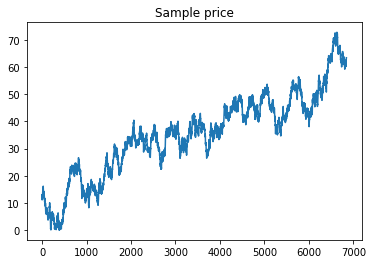

Starting episode 1
Episode 1:0/1500	Last reward: 112052.41	Average reward: 112052.41	Avg. loss: 2394.92
Episode 1:1/1500	Last reward: 1831.63	Average reward: 56942.02	Avg. loss: 2298.56
Episode 1:2/1500	Last reward: 7255996.56	Average reward: 2456626.87	Avg. loss: 2273.07
Episode 1:3/1500	Last reward: 456815.54	Average reward: 1956674.04	Avg. loss: 2483.08
Episode 1:4/1500	Last reward: -4192.56	Average reward: 1564500.72	Avg. loss: 2263.98
Episode 1:5/1500	Last reward: 116129.58	Average reward: 1323105.53	Avg. loss: 2103.67
Episode 1:6/1500	Last reward: 1493121.02	Average reward: 1347393.46	Avg. loss: 2137.54
Episode 1:7/1500	Last reward: -995.21	Average reward: 1178844.87	Avg. loss: 2109.82
Episode 1:8/1500	Last reward: -5866.82	Average reward: 1047210.24	Avg. loss: 2054.96
Episode 1:9/1500	Last reward: 3408821.52	Average reward: 1283371.37	Avg. loss: 2096.42
Episode 1:10/1500	Last reward: 40160874.08	Average reward: 4817689.80	Avg. loss: 2130.79
Episode 1:11/1500	Last reward: 658706.

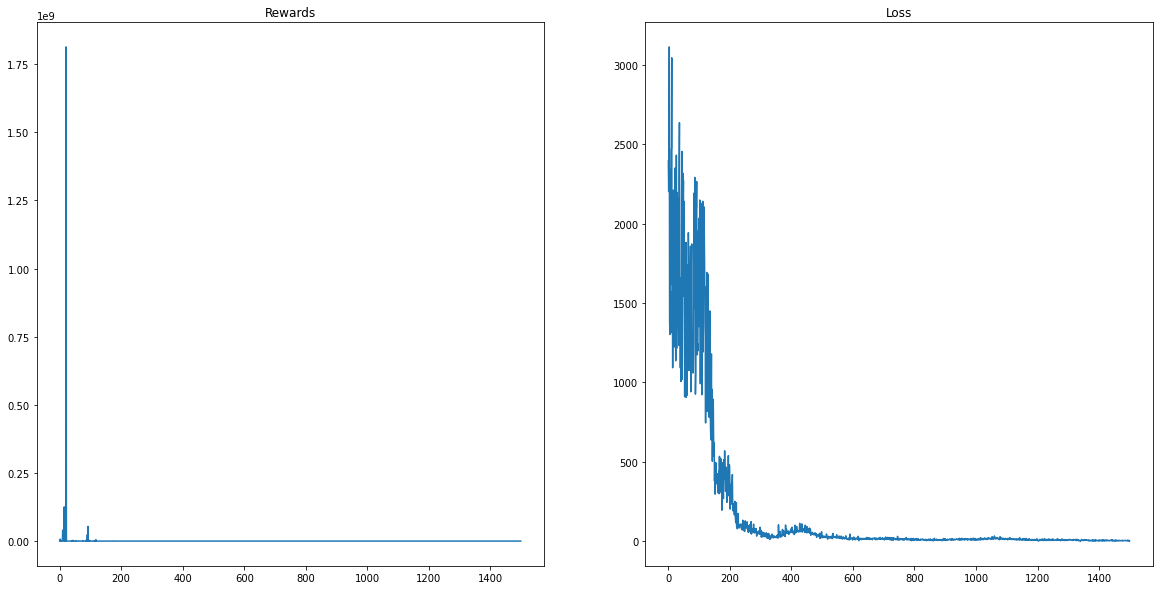

In [10]:
print('starting...')
window = 28

agent = Agent(load_existing=False, window=window)
# agent.train(epochs=1000, episodes=1, num_samples=365)
agent.train(epochs=1500, episodes=1, num_samples=6843)
# agent.train(epochs=100, episodes=1, num_samples=27375)
#     agent.train(epochs=10, episodes=10, num_samples=54750)
#     agent.train(epochs=10, episodes=20, num_samples=109500)




In [9]:
# drive.mount('/content/drive')
# print(os.listdir())

# df = pd.read_csv('drive/My Drive/Colab Notebooks/data_btc/btc_etf_data_adj_close.csv')
# df = df[df.date > '2017-06-01']
# data = df['BTC-EUR'].values
# data2 = df['ETH-EUR'].values

# agent = Agent(load_existing=True, window=window)
# evaluator = MarketAgentEvaluator(agent)
# evaluator.evaluate(data, window=window)
# evaluator.plot()
# evaluator.print()

# evaluator = MarketAgentEvaluator(agent)
# evaluator.evaluate(data2, window=window)
# evaluator.plot()
# evaluator.print()